In [ ]:
##########################################
## this script is using the d3 - d5 scRNA-seq after regressing out the cell-cycle scores
## 
##########################################

In [1]:
import os, sys
#!{sys.executable} -m pip -q install palantir fa2
import warnings
warnings.filterwarnings("ignore")

In [2]:
# to avoid any possible jupyter crashes due to rpy2 not finding the R install on conda
os.environ['R_HOME'] = sys.exec_prefix+"/lib/R/"

In [3]:
from anndata import AnnData
import numpy as np
import pandas as pd
import scanpy as sc
import scFates as scf
import palantir

by .GlobalEnv when processing object ‘aa’


In [4]:
import matplotlib
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = "Comic Sans MS"

sc.settings.verbosity = 3
sc.settings.logfile = sys.stdout

In [5]:
import matplotlib.pyplot as plt

In [6]:
## fix palantir breaking down some plots
import seaborn
seaborn.reset_orig()
%matplotlib inline
sc.set_figure_params()
scf.set_figure_pubready()

In [7]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']

In [8]:
data_dir = "../results/scRNAseq_R13547_10x_mNT_20220813/RA_symetryBreaking/TF_modules/d3_d5_TFs_SPs_regressingCellCycle_v1/"
outDir = data_dir
sc.settings.figdir = os.path.join(outDir, "figures/")

In [9]:
file_path = os.path.join(data_dir, "RNAmatrix_RA_allGenes_d3_d5_TFs_SPs_regressingCellCycle_v1.h5ad")

In [10]:
import matplotlib
print(matplotlib.matplotlib_fname())

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/matplotlib/mpl-data/matplotlibrc


In [11]:
## import Rory's funcitons from https://github.com/rorymaizels/Maizels2023aa/blob/main/analysis/A2.2_benchmarking/A2.2.1_making_benchmark_datasets.ipynb
from cellrank.kernels import PseudotimeKernel
def process_for_pseudotime(adata, layer, n_neighbors=50):
    X = adata.layers[layer]
    X = X.A if issparse(X) else X
    
    Xlog = np.log1p(X)
    pca = PCA()
    Xpca = pca.fit_transform(Xlog)
    adata.obsm['X_pca'] = Xpca
    adata.varm['precomputed_PCs'] = pca.components_
    
    if n_neighbors > 0:
        cnx = vt.pp.connectivities(total=X, n_neighbors=n_neighbors)
        Xsmooth = vt.pp.moments(X=X, cnx=cnx, n_neighbors=n_neighbors)
        Xlogsmooth = np.log1p(Xsmooth)
        pca = PCA()
        Xpcasmooth = pca.fit_transform(Xlogsmooth)
        adata.obsm['X_pca_smooth'] = Xpcasmooth
    else:
        adata.obsm['X_pca_smooth'] = Xpca
    return adata

def run_tree(
    adata, 
    layer,
    n_nodes=200,
    seed=1,
    ppt_lambda=50,
    ppt_sigma=1.5,
    ndims_rep=50,
    figsize=(9,4),
    dimensions=[[0,1],[0,2]],
    color='cell_annotation'
    ):
    scf.tl.tree(adata, method="ppt",Nodes=n_nodes, use_rep="X_pca_smooth",
                device="cpu",seed=seed,ppt_lambda=ppt_lambda,ppt_sigma=ppt_sigma,
                ppt_nsteps=300, ndims_rep=ndims_rep)
    fig = plt.figure(figsize=figsize)
    ax1, ax2 = fig.subplots(1,2)
    scf.pl.graph(adata, size=50, color_cells=color, basis='pca', 
                 ax=ax1, dimensions=dimensions[0], show=False, forks=False)
    scf.pl.graph(adata, size=50, color_cells=color, basis='pca', 
                 ax=ax2, dimensions=dimensions[1], show=False, forks=False)
    print(f"Tips: {adata.uns['graph']['tips']}")
    print()
    print(f"Forks: {adata.uns['graph']['forks']}")
    plt.show()

def run_pseudotime(adata, root, n_maps=10):    
    scf.tl.root(
        adata,
        root
    )

    scf.tl.pseudotime(
        adata,
        n_jobs=20,
        n_map=n_maps,
        seed=42
    )
    adata.obs['seg'] = adata.obs['seg'].astype('category')
    scf.pl.trajectory(adata, basis='pca', color_cells='seg')

def get_cell_pseudotime_vector(adata, cell_idx, basis='pca', ndim=50):
    idx = adata.uns['graph']['pp_info'].sort_values('time').PP.values
    points = adata.uns['graph']['F'].T[idx]
    segs = adata.uns['graph']['pp_info'].seg.values[idx]
    
    
    cell = adata[cell_idx]
    cell_rep = cell.obsm[f'X_{basis}'][:,:ndim]
    cell_seg = cell.obs.seg.values[0]
    
    seg_points = points[segs==cell_seg][:,:ndim]
    best = np.sqrt(np.sum((cell_rep - seg_points)**2, axis=1)).argmin()
    try:
        vector = seg_points[best+1] - seg_points[best]
    except IndexError:
        vector = np.zeros_like(seg_points[best])
    return vector

def calculate_pseudotime_vectorfield(adata, ndim=50, basis='pca'):
    vf = np.zeros_like(adata.obsm[f"X_{basis}"][:,:ndim])
    for i in trange(adata.shape[0]):
        vf[i,:] = get_cell_pseudotime_vector(adata, cell_idx=i, basis=basis, ndim=ndim)
    adata.obsm['velocity_pst'] = vf
    adata.obsm['X_pst'] = adata.obsm[f"X_{basis}"][:,:ndim]
    
def viz(adata, genes):
    """
    we don't want to keep the log transformed data or PCA, but want to viz
    """
    copy = adata.copy()    
    sc.pp.log1p(copy)
    sc.pp.pca(copy)
    sc.pl.pca(copy, color=['cell_annotation','timepoint','rep'])
    
def calculate_cellrank_vectorfield(adata, ndim=50, basis='pca'):
    cnx = vt.pp.connectivities(total=adata.layers['total'], n_neighbors=30)
    adata.obsp['neighbors_connectivities'] = cnx
    pk = PseudotimeKernel(adata, time_key='t')
    pk.compute_transition_matrix()
    pk.plot_projection(basis='pca', key_added='velocity_cr')
    adata.obsm['X_cr_pca'] = adata.obsm[f"X_{basis}"][:,:ndim]

In [12]:
# Load sample data
adata = sc.read(file_path, chunk_size=6000)

In [13]:
## processing steps

In [14]:
#counts = palantir.io.from_csv('https://github.com/dpeerlab/Palantir/raw/master/data/marrow_sample_scseq_counts.csv.gz')
#norm_df = sc.pp.normalize_per_cell(counts,copy=True)
#norm_df = palantir.preprocess.log_transform(norm_df)
adata

AnnData object with n_obs × n_vars = 8000 × 2001
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'iscell_dd', 'cell.id', 'percent.mt', 'DF_out', 'percent.rb', 'S.Score', 'G2M.Score', 'Phase', 'celltypes', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.7', 'clusters', 'time', 'dataset'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [15]:
adata.obsm["X_seurat_pca"] = adata.obsm["X_pca"]
adata.obsm["X_seurat_umap"] = adata.obsm["X_umap"]

In [16]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "serif",
    # Use LaTeX default serif font.
    "font.serif": [],
    # Use specific cursive fonts.
    "font.cursive": ["Comic Neue", "Comic Sans MS"],
})

In [17]:
import matplotlib as mpl
print(mpl.get_cachedir())

/users/jingkui.wang/.cache/matplotlib


In [18]:
# basic filtering from scanpy, original code from https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html
#sc.pl.highest_expr_genes(adata, n_top=20)
#sc.pp.filter_cells(adata, min_genes=200)
#sc.pp.filter_genes(adata, min_cells=5)

In [19]:
adata

AnnData object with n_obs × n_vars = 8000 × 2001
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'iscell_dd', 'cell.id', 'percent.mt', 'DF_out', 'percent.rb', 'S.Score', 'G2M.Score', 'Phase', 'celltypes', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.7', 'clusters', 'time', 'dataset'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap', 'X_seurat_pca', 'X_seurat_umap'
    varm: 'PCs'

In [20]:
#sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.normalize_per_cell(adata)
#palantir.preprocess.log_transform(adata)
#sc.pp.log1p(adata)

In [21]:
#adata=sc.AnnData(norm_df)
#sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='cell_ranger')
#sc.pp.pca(adata, n_comps = 50)

In [22]:
adata

AnnData object with n_obs × n_vars = 8000 × 2001
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'iscell_dd', 'cell.id', 'percent.mt', 'DF_out', 'percent.rb', 'S.Score', 'G2M.Score', 'Phase', 'celltypes', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.7', 'clusters', 'time', 'dataset'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap', 'X_seurat_pca', 'X_seurat_umap'
    varm: 'PCs'

In [23]:
# test Rory's function, not used for the moment
#adata.layers['X']
#Xlog = np.log1p(adata)
#from sklearn.decomposition import PCA
#pca = PCA()
#Xpca = pca.fit_transform(Xlog)
#adata.obsm['X_pca'] = Xpca
#adata.varm['precomputed_PCs'] = pca.components_
#adata = process_for_pseudotime(adata, 'total')

In [24]:
adata

AnnData object with n_obs × n_vars = 8000 × 2001
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'iscell_dd', 'cell.id', 'percent.mt', 'DF_out', 'percent.rb', 'S.Score', 'G2M.Score', 'Phase', 'celltypes', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.7', 'clusters', 'time', 'dataset'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap', 'X_seurat_pca', 'X_seurat_umap'
    varm: 'PCs'

In [25]:
pca_projections = pd.DataFrame(adata.obsm["X_seurat_pca"],index=adata.obs_names)

In [26]:
dm_res = palantir.utils.run_diffusion_maps(pca_projections)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)


In [27]:
ms_data = palantir.utils.determine_multiscale_space(dm_res, n_eigs=5)
ms_data

0         1         2         3
AAACGAACAACTTGGT-1_1_1_1_1_1_1  0.084067  0.062232 -0.026413 -0.043878
AAAGAACAGAGGCGTT-1_1_1_1_1_1_1  0.077046  0.058183 -0.021880 -0.053484
AAAGAACCATGTGTCA-1_1_1_1_1_1_1  0.084561  0.068497 -0.026300 -0.064704
AAAGAACTCTTCTAAC-1_1_1_1_1_1_1  0.076185  0.055530 -0.017900 -0.039331
AAAGGGCAGGATACCG-1_1_1_1_1_1_1  0.071725  0.038653 -0.019610 -0.022832
...                                  ...       ...       ...       ...
TTTGGAGCAGGAACCA-1_2_1         -0.027769 -0.122592 -0.040302 -0.019186
TTTGGTTCAGGCGAAT-1_2_1          0.046185 -0.038639 -0.013503  0.104606
TTTGGTTGTTAAGCAA-1_2_1         -0.042045 -0.148752 -0.068995 -0.058854
TTTGTTGAGACCATGG-1_2_1         -0.276076  0.033418  0.037976 -0.010091
TTTGTTGAGGTGGTTG-1_2_1          0.031268 -0.068594 -0.025785  0.059374

[8000 rows x 4 columns]

In [28]:
adata.obsm["X_palantir"]=ms_data.values

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:01:16)


/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were fo

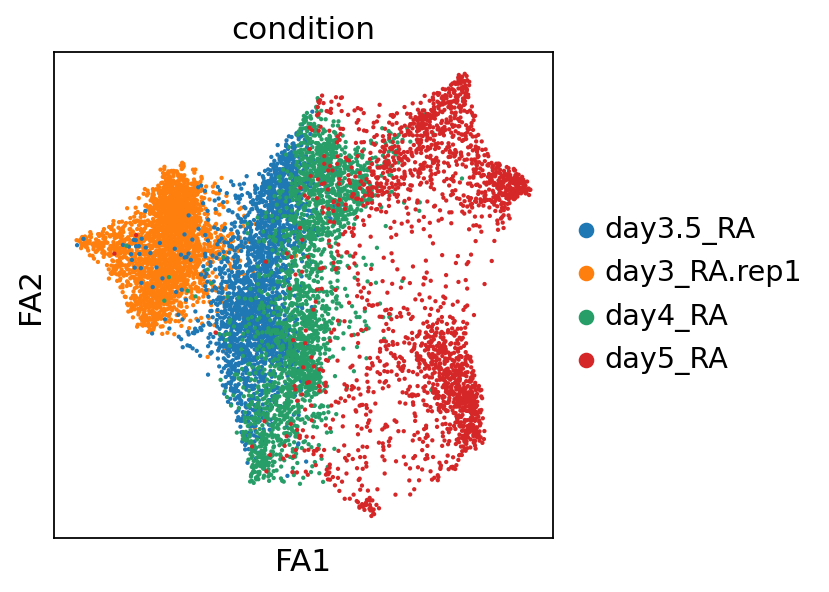

In [29]:
# generate neighbor draph in multiscale diffusion space
sc.pp.neighbors(adata, n_neighbors=30, use_rep="X_seurat_pca", n_pcs = 20)
# draw ForceAtlas2 embedding using 2 first PCs as initial positions
adata.obsm["X_pca2d"]=adata.obsm["X_seurat_umap"][:,:2]
sc.tl.draw_graph(adata, init_pos='X_pca2d')
sc.pl.draw_graph(adata, color="condition",color_map="RdBu_r")

In [30]:
adata

AnnData object with n_obs × n_vars = 8000 × 2001
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'iscell_dd', 'cell.id', 'percent.mt', 'DF_out', 'percent.rb', 'S.Score', 'G2M.Score', 'Phase', 'celltypes', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.7', 'clusters', 'time', 'dataset'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'neighbors', 'draw_graph', 'condition_colors'
    obsm: 'X_pca', 'X_umap', 'X_seurat_pca', 'X_seurat_umap', 'X_palantir', 'X_pca2d', 'X_draw_graph_fa'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were fo

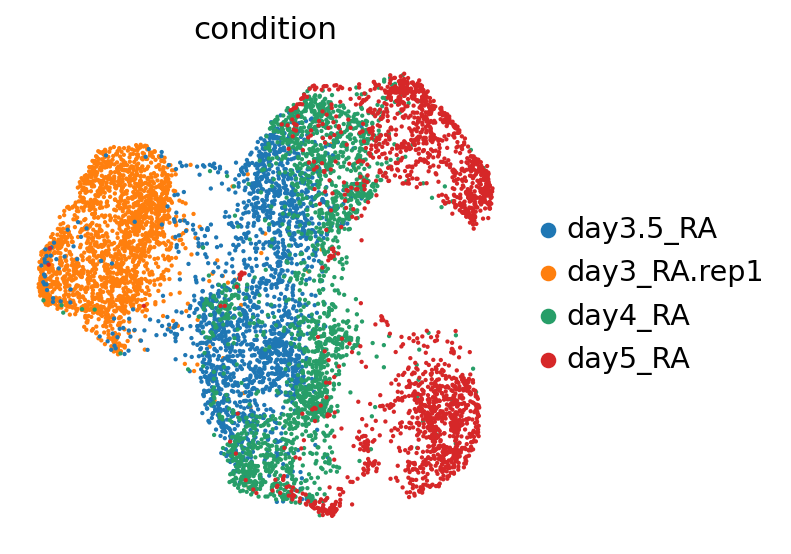

In [31]:
sc.pl.embedding(
    adata,
    basis="umap",
    color = 'condition',
    frameon=False,
)

In [32]:
# sc.pl.pca(adata, color=['condition'], components='2,3')

In [33]:
adata

AnnData object with n_obs × n_vars = 8000 × 2001
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'iscell_dd', 'cell.id', 'percent.mt', 'DF_out', 'percent.rb', 'S.Score', 'G2M.Score', 'Phase', 'celltypes', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.7', 'clusters', 'time', 'dataset'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'neighbors', 'draw_graph', 'condition_colors'
    obsm: 'X_pca', 'X_umap', 'X_seurat_pca', 'X_seurat_umap', 'X_palantir', 'X_pca2d', 'X_draw_graph_fa'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [34]:
#Tree learning with SimplePPT

inferring a principal tree --> parameters used 
    200 principal points, sigma = 0.006, lambda = 40, metric = euclidean
    fitting:  12%|█▎        | 25/200 [00:02<00:19,  9.04it/s]
    converged
    more than 30 tips detected!
    finished (0:00:02) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families

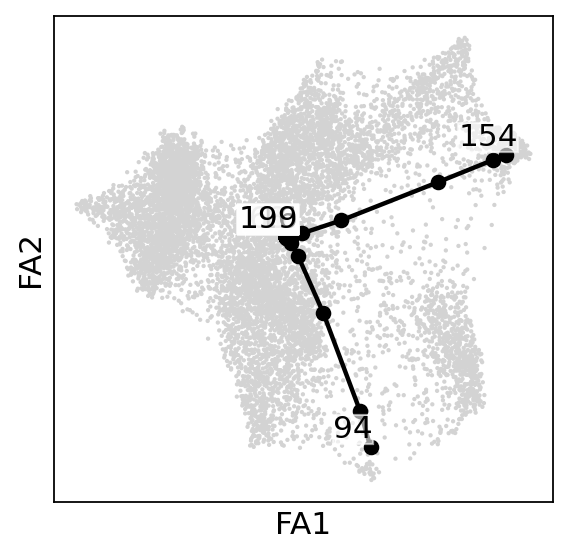

In [52]:
scf.tl.tree(adata,method="ppt", Nodes=200, use_rep="X_seurat_pca", 
            ndims_rep=20,
            device="cpu",
            seed=1,
            ppt_lambda=40,
            ppt_sigma=0.006,
            ppt_nsteps=200)
scf.pl.graph(adata)

inferring a principal tree --> parameters used 
    100 principal points, sigma = 0.035, lambda = 200, metric = euclidean
    fitting:  28%|██▊       | 57/200 [00:04<00:11, 12.69it/s]
    converged


/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 


    finished (0:00:04) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because

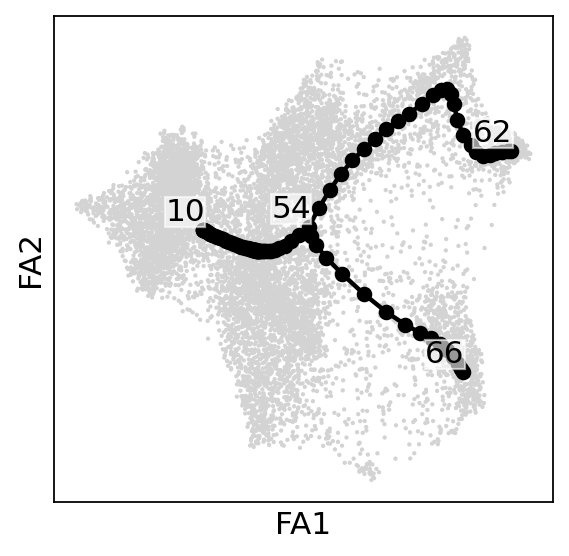

In [91]:
scf.tl.tree(adata, method="ppt", Nodes=100, use_rep="X_palantir", 
            ndims_rep=3,
            device="cpu",
            seed=1,
            ppt_lambda=200,
            ppt_sigma=0.035,
            ppt_nsteps=200)
scf.pl.graph(adata)

inferring a principal tree --> parameters used 
    100 principal points, sigma = 1.0, lambda = 200, metric = euclidean
    fitting:  22%|██▏       | 44/200 [00:02<00:10, 14.98it/s]
    converged


/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
findfont: Generic family 'serif' not found because none of the following families were found: 


    finished (0:00:02) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because

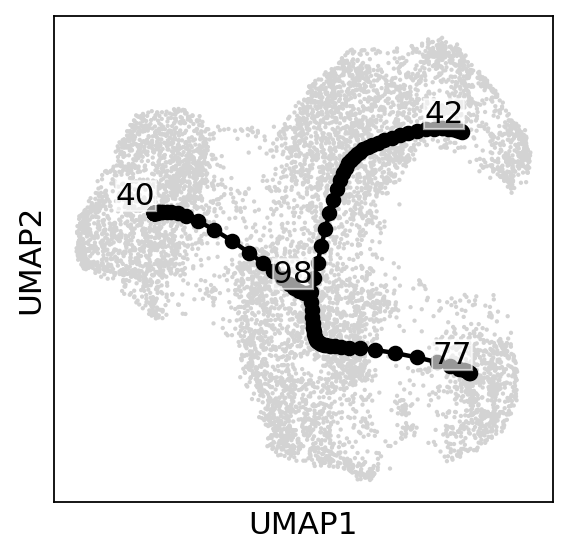

In [63]:
scf.tl.tree(adata, method="ppt", Nodes=100, use_rep="X_seurat_umap", 
            #ndims_rep=20,
            device="cpu",
            seed=1,
            ppt_lambda=200,
            ppt_sigma=1.0,
            ppt_nsteps=200)

# projecting results onto ForceAtlas2 embedding
scf.pl.graph(adata, basis = 'umap')

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families

    graph cleaned --> removed 0 principal points


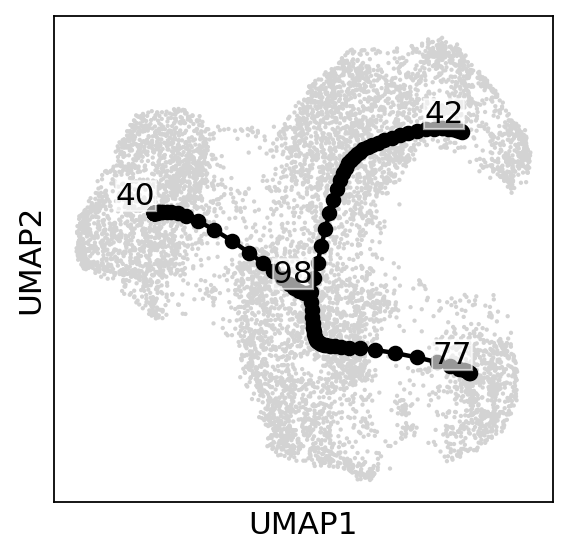

In [64]:
scf.tl.cleanup(adata,minbranchlength=10);
scf.pl.graph(adata, basis = 'umap')

In [65]:
# Selecting a root and computing pseudotime
# Using CD34 marker, we can confidently tell that the tip 163 is the root.
scf.tl.root(adata, 40)

node 40 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.


In [66]:
# Here we are going to generate 100 mappings of pseudotime, to account for cell asssignment uncertainty. 
# to .obs will be saved the mean of all calculated pseudotimes.
# exmaple data takes > 360G memory and 16 nodes
scf.tl.pseudotime(adata, seed=42, n_jobs=20, n_map=100)

projecting cells onto the principal graph
    mappings:   0%|          | 0/100 [00:00<?, ?it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’


    mappings:   3%|▎         | 3/100 [01:19<42:36, 26.35s/it]  

by .GlobalEnv when processing object ‘aa’


    mappings:   4%|▍         | 4/100 [01:19<31:58, 19.98s/it]

by .GlobalEnv when processing object ‘aa’


    mappings:   5%|▌         | 5/100 [01:21<25:48, 16.30s/it]

by .GlobalEnv when processing object ‘aa’


    mappings:   6%|▌         | 6/100 [01:21<21:18, 13.60s/it]

by .GlobalEnv when processing object ‘aa’


    mappings:   8%|▊         | 8/100 [01:23<16:05, 10.50s/it]

by .GlobalEnv when processing object ‘aa’


    mappings:  10%|█         | 10/100 [01:25<12:51,  8.57s/it]

by .GlobalEnv when processing object ‘aa’


    mappings:  11%|█         | 11/100 [01:27<11:45,  7.92s/it]

by .GlobalEnv when processing object ‘aa’


    mappings: 100%|██████████| 100/100 [02:04<00:00,  1.25s/it]
    finished (0:02:10) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


In [67]:
adata

AnnData object with n_obs × n_vars = 8000 × 2001
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'iscell_dd', 'cell.id', 'percent.mt', 'DF_out', 'percent.rb', 'S.Score', 'G2M.Score', 'Phase', 'celltypes', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.7', 'clusters', 'time', 'dataset', 't', 'seg', 'edge', 't_sd', 'milestones'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'neighbors', 'draw_graph', 'condition_colors', 'graph', 'ppt', 'pseudotime_list', 'milestones_colors', 'seg_colors'
    obsm: 'X_pca', 'X_umap', 'X_seurat_pca', 'X_seurat_umap', 'X_palantir', 'X_pca2d', 'X_draw_graph_fa', 'X_R'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [68]:
# save the intermediate file, that takes long time to compute
adata.write(os.path.join(outDir,'scFates_pseudotime_mNT_d3_d5.h5ad'), compression="gzip")

In [69]:
adata = sc.read_h5ad(os.path.join(outDir,'scFates_pseudotime_mNT_d3_d5.h5ad'),chunk_size=6000)

In [70]:
adata

AnnData object with n_obs × n_vars = 8000 × 2001
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'iscell_dd', 'cell.id', 'percent.mt', 'DF_out', 'percent.rb', 'S.Score', 'G2M.Score', 'Phase', 'celltypes', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.7', 'clusters', 'time', 'dataset', 't', 'seg', 'edge', 't_sd', 'milestones'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'condition_colors', 'draw_graph', 'graph', 'milestones_colors', 'neighbors', 'ppt', 'pseudotime_list', 'seg_colors'
    obsm: 'X_R', 'X_draw_graph_fa', 'X_palantir', 'X_pca', 'X_pca2d', 'X_seurat_pca', 'X_seurat_umap', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families

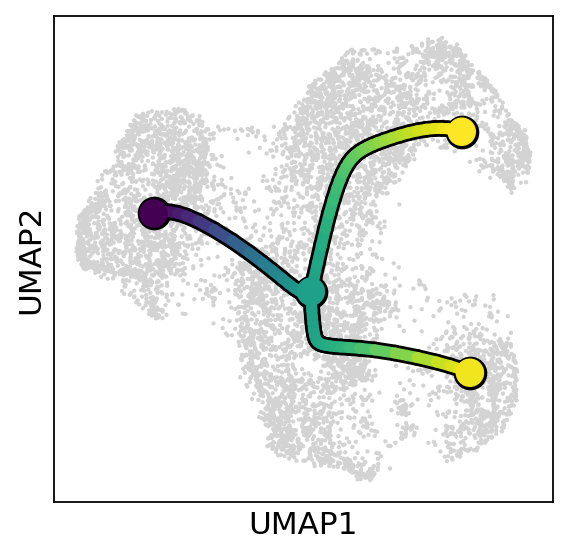

In [71]:
# Representing the trajectory and tree on top of existing embedding
scf.pl.trajectory(adata, basis = 'umap')

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' 

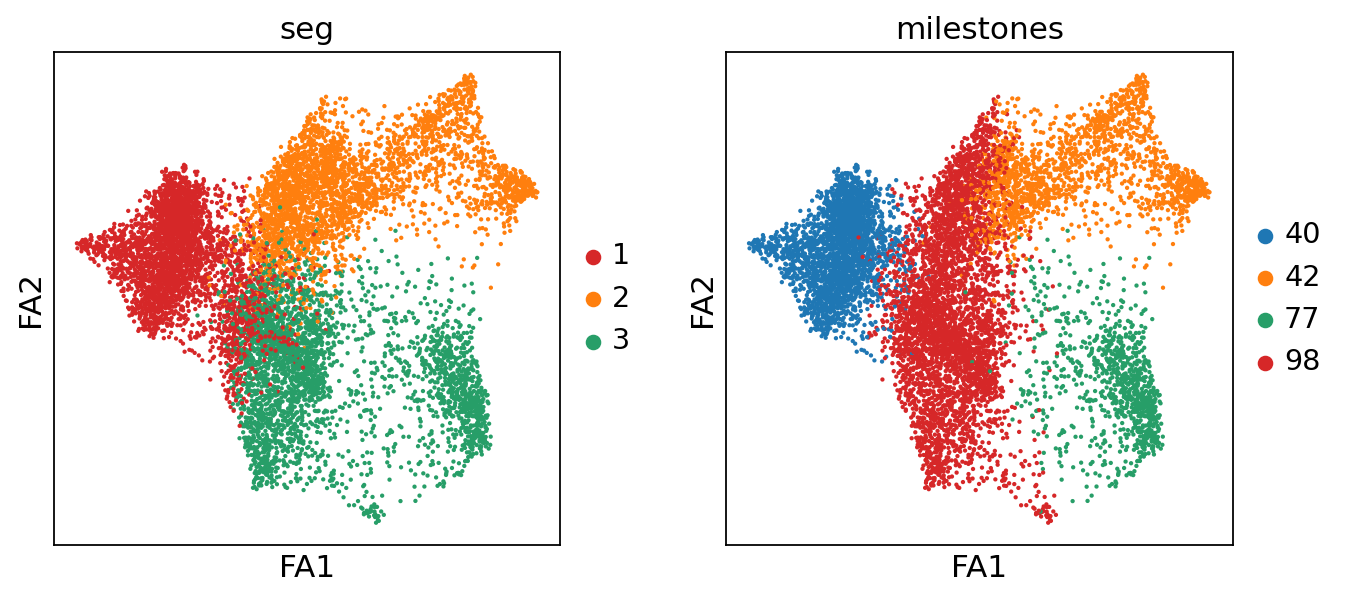

In [72]:
sc.pl.draw_graph(adata,color=["seg","milestones"])

findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because

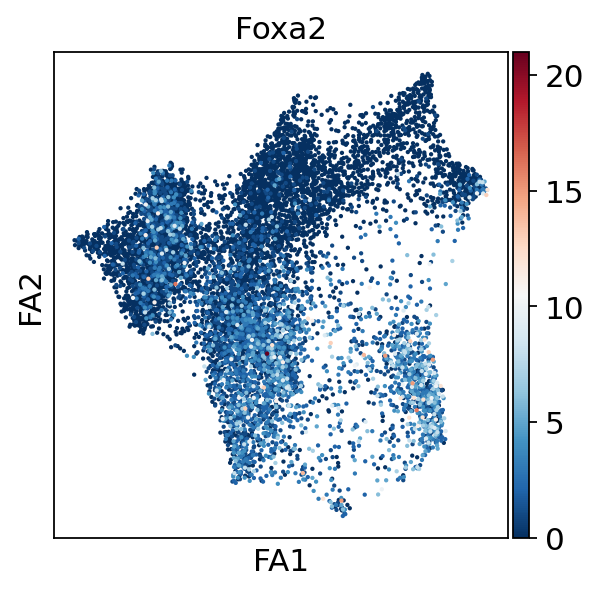

In [73]:
sc.pl.draw_graph(adata,color="Foxa2",color_map="RdBu_r")

In [75]:
scf.tl.rename_milestones(adata,["Root", "NP", "FP",  "Bifu"])
# we change the color of the root milestone for better visualisations
adata.uns["milestones_colors"][3]="#17bece"

In [76]:
from pathlib import Path
Path(os.path.join(outDir, "figures/")).mkdir(parents=True, exist_ok=True)

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


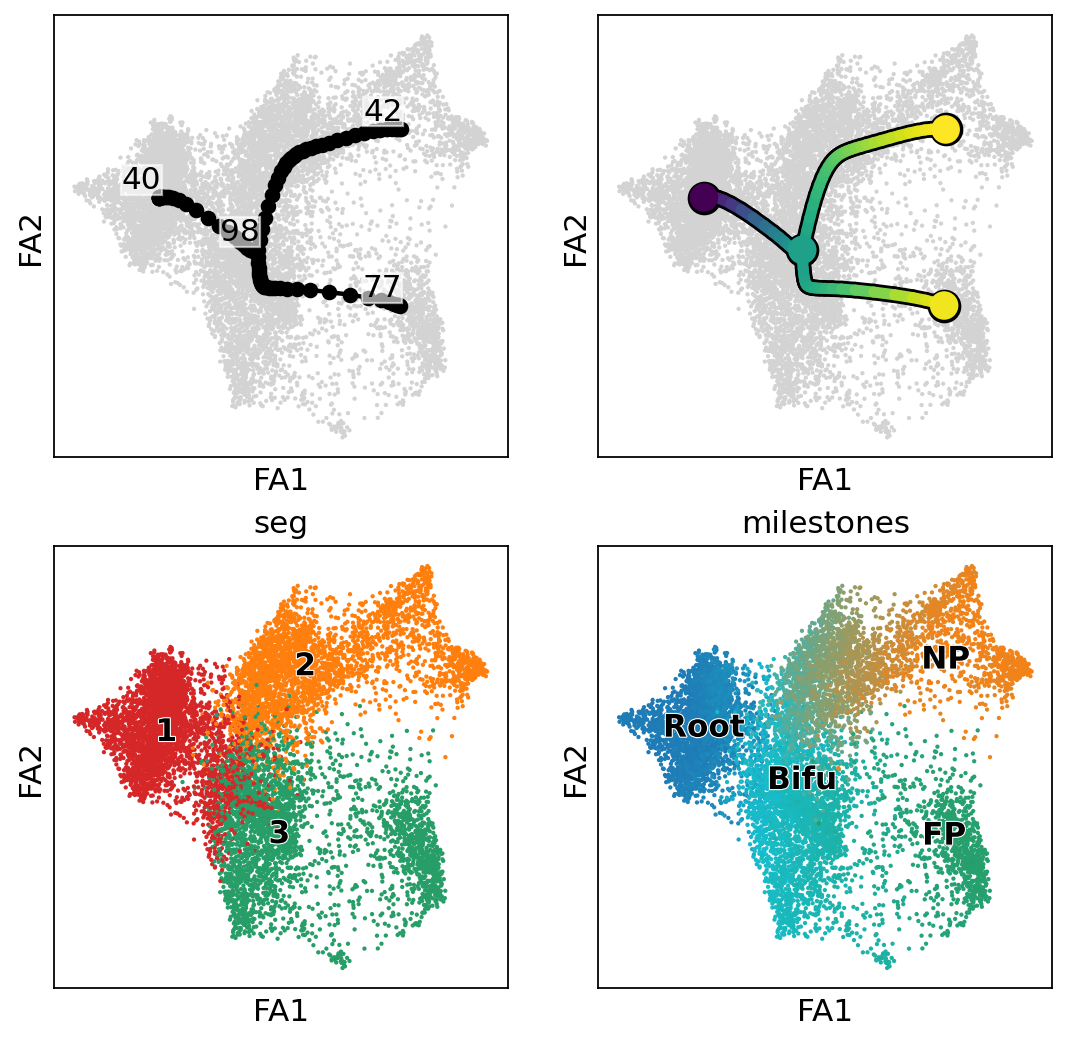

In [77]:
sc.set_figure_params()
fig, axs=plt.subplots(2,2,figsize=(8,8))
axs=axs.ravel()
scf.pl.graph(adata,basis="draw_graph_fa",show=False,ax=axs[0])
scf.pl.trajectory(adata,basis="draw_graph_fa",show=False,ax=axs[1])
sc.pl.draw_graph(adata,color=["seg"],legend_loc="on data",show=False,ax=axs[2],legend_fontoutline=True)
scf.pl.milestones(adata,ax=axs[3],show=False,annotate=True)
plt.savefig(os.path.join(outDir, "figures/A.pdf"),dpi=300)

In [78]:
# as a dendrogram representation (take some 5-10 minutes)
scf.tl.dendrogram(adata)

Generating dendrogram of tree
    segment : 100%|██████████| 3/3 [00:16<00:00,  5.37s/it]
    finished (0:00:16) --> added 
    .obsm['X_dendro'], new embedding generated.
    .uns['dendro_segments'] tree segments used for plotting.


/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were fo

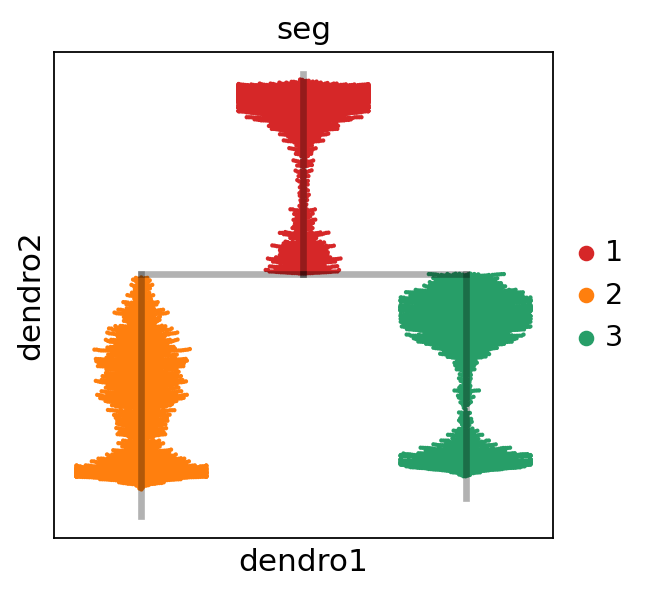

In [79]:
scf.pl.dendrogram(adata,color="seg")

findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because

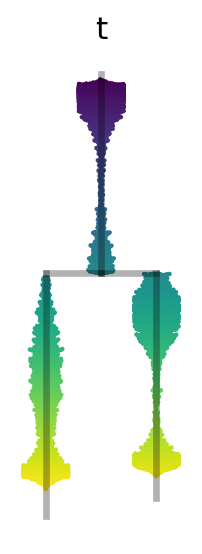

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because

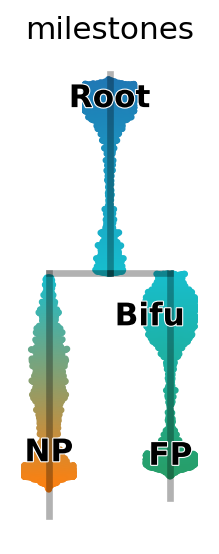

In [80]:
sc.set_figure_params(figsize=(1.5,4),frameon=False,dpi_save=300)
scf.pl.dendrogram(adata,color="t",show_info=False,
                  save="B1.pdf",
                  cmap="viridis")
scf.pl.dendrogram(adata,color="milestones",legend_loc="on data",
                  color_milestones=True,legend_fontoutline=True, 
                  save="B2.pdf")


In [81]:
# save the intermediate file, that takes long time to compute
adata.write(os.path.join(outDir,'scFates_pseudotime_mNT_d3_d5_before.test.asssociation.h5ad'), compression="gzip")

In [82]:
adata = sc.read_h5ad(os.path.join(outDir,'scFates_pseudotime_mNT_d3_d5_before.test.asssociation.h5ad'),chunk_size=6000)

In [83]:
# Test and fit features associated with the tree
scf.tl.test_association(adata,n_jobs=20, A_cut=0.5)

test features for association with the trajectory
    single mapping :   7%|▋         | 142/2001 [00:09<02:01, 15.29it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :   7%|▋         | 150/2001 [00:18<03:43,  8.28it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :   8%|▊         | 157/2001 [00:24<04:52,  6.30it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :   8%|▊         | 159/2001 [00:32<06:17,  4.88it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :   8%|▊         | 164/2001 [00:40<07:35,  4.04it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :   9%|▊         | 174/2001 [00:48<08:31,  3.57it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :   9%|▉         | 181/2001 [00:55<09:21,  3.24it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :   9%|▉         | 182/2001 [01:02<10:21,  2.93it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :   9%|▉         | 190/2001 [01:09<10:59,  2.75it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .Glo

    single mapping :  10%|▉         | 195/2001 [01:42<15:45,  1.91it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  10%|█         | 202/2001 [01:49<16:15,  1.84it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  10%|█         | 204/2001 [01:56<17:04,  1.75it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  10%|█         | 206/2001 [02:03<17:59,  1.66it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  10%|█         | 209/2001 [02:10<18:41,  1.60it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  10%|█         | 210/2001 [02:24<20:28,  1.46it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  11%|█         | 211/2001 [02:31<21:21,  1.40it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  12%|█▏        | 244/2001 [02:37<18:55,  1.55it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  17%|█▋        | 337/2001 [02:51<14:06,  1.96it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  18%|█▊        | 360/2001 [03:00<13:44,  1.99it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  18%|█▊        | 365/2001 [03:09<14:08,  1.93it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  18%|█▊        | 367/2001 [03:15<14:30,  1.88it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  18%|█▊        | 368/2001 [03:22<15:00,  1.81it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  18%|█▊        | 369/2001 [03:29<15:26,  1.76it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  19%|█▊        | 372/2001 [03:37<15:51,  1.71it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  19%|█▊        | 373/2001 [03:51<16:50,  1.61it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  19%|█▉        | 376/2001 [03:57<17:06,  1.58it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  19%|█▉        | 378/2001 [04:04<17:29,  1.55it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  19%|█▉        | 384/2001 [04:10<17:34,  1.53it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  21%|██        | 419/2001 [04:18<16:16,  1.62it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  25%|██▌       | 502/2001 [04:34<13:38,  1.83it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  26%|██▌       | 517/2001 [04:41<13:27,  1.84it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  26%|██▌       | 523/2001 [04:48<13:36,  1.81it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  26%|██▋       | 527/2001 [04:55<13:45,  1.79it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’


    single mapping :  26%|██▋       | 529/2001 [05:02<14:01,  1.75it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  27%|██▋       | 538/2001 [05:09<14:00,  1.74it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  27%|██▋       | 547/2001 [05:16<14:01,  1.73it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  27%|██▋       | 548/2001 [05:23<14:17,  1.69it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  28%|██▊       | 552/2001 [05:31<14:31,  1.66it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can b

    single mapping :  28%|██▊       | 556/2001 [05:51<15:13,  1.58it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  30%|███       | 604/2001 [06:00<13:54,  1.67it/s]

by .GlobalEnv when processing object ‘aa’


    single mapping :  34%|███▍      | 677/2001 [06:06<11:57,  1.85it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  34%|███▍      | 681/2001 [06:14<12:06,  1.82it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  34%|███▍      | 685/2001 [06:20<12:10,  1.80it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  35%|███▍      | 700/2001 [06:26<11:58,  1.81it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  35%|███▌      | 710/2001 [06:34<11:57,  1.80it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  36%|███▌      | 711/2001 [06:42<12:10,  1.77it/s]

by .GlobalEnv when processing object ‘aa’


    single mapping :  36%|███▌      | 715/2001 [06:42<12:03,  1.78it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  36%|███▌      | 719/2001 [06:50<12:12,  1.75it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  36%|███▌      | 722/2001 [07:05<12:33,  1.70it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  36%|███▋      | 726/2001 [07:13<12:41,  1.67it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  36%|███▋      | 727/2001 [07:27<13:04,  1.62it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  36%|███▋      | 728/2001 [07:34<13:14,  1.60it/s]

by .GlobalEnv when processing object ‘aa’


    single mapping :  36%|███▋      | 730/2001 [07:34<13:11,  1.61it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  37%|███▋      | 739/2001 [07:42<13:09,  1.60it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  41%|████      | 815/2001 [07:54<11:30,  1.72it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  44%|████▎     | 871/2001 [08:04<10:29,  1.80it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  44%|████▍     | 883/2001 [08:11<10:22,  1.79it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  44%|████▍     | 887/2001 [08:19<10:27,  1.78it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  45%|████▍     | 891/2001 [08:33<10:40,  1.73it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  45%|████▍     | 892/2001 [08:41<10:48,  1.71it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  45%|████▍     | 894/2001 [08:55<11:03,  1.67it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can b

    single mapping :  45%|████▌     | 902/2001 [09:17<11:19,  1.62it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  46%|████▌     | 912/2001 [09:24<11:13,  1.62it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  50%|█████     | 1002/2001 [09:37<09:35,  1.73it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  52%|█████▏    | 1039/2001 [09:47<09:04,  1.77it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  53%|█████▎    | 1052/2001 [09:58<09:00,  1.76it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  53%|█████▎    | 1058/2001 [10:07<09:01,  1.74it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  53%|█████▎    | 1064/2001 [10:13<09:00,  1.73it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  53%|█████▎    | 1065/2001 [10:21<09:05,  1.71it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  53%|█████▎    | 1066/2001 [10:35<09:17,  1.68it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’


    single mapping :  53%|█████▎    | 1067/2001 [10:42<09:21,  1.66it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  53%|█████▎    | 1068/2001 [10:55<09:32,  1.63it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  56%|█████▌    | 1121/2001 [11:12<08:47,  1.67it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  58%|█████▊    | 1153/2001 [11:20<08:20,  1.69it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  59%|█████▉    | 1184/2001 [11:30<07:56,  1.71it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  60%|██████    | 1202/2001 [11:40<07:45,  1.72it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  60%|██████    | 1209/2001 [11:54<07:47,  1.69it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  61%|██████    | 1212/2001 [12:03<07:50,  1.68it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  61%|██████    | 1217/2001 [12:10<07:50,  1.67it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’


    single mapping :  61%|██████    | 1221/2001 [12:16<07:50,  1.66it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  61%|██████    | 1222/2001 [12:25<07:55,  1.64it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  61%|██████    | 1224/2001 [12:31<07:57,  1.63it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  61%|██████▏   | 1226/2001 [12:38<07:59,  1.62it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  63%|██████▎   | 1251/2001 [12:44<07:38,  1.64it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  64%|██████▍   | 1289/2001 [12:54<07:07,  1.67it/s]

by .GlobalEnv when processing object ‘aa’


    single mapping :  67%|██████▋   | 1347/2001 [12:59<06:18,  1.73it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  68%|██████▊   | 1364/2001 [13:07<06:07,  1.73it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  68%|██████▊   | 1369/2001 [13:15<06:07,  1.72it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  69%|██████▉   | 1376/2001 [13:23<06:05,  1.71it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  69%|██████▉   | 1377/2001 [13:30<06:07,  1.70it/s]

by .GlobalEnv when processing object ‘aa’


    single mapping :  69%|██████▉   | 1382/2001 [13:30<06:03,  1.70it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  69%|██████▉   | 1390/2001 [13:36<05:58,  1.70it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  70%|██████▉   | 1394/2001 [13:44<05:58,  1.69it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  70%|██████▉   | 1396/2001 [13:57<06:02,  1.67it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  70%|██████▉   | 1400/2001 [14:04<06:02,  1.66it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  70%|███████   | 1401/2001 [14:18<06:07,  1.63it/s]

by .GlobalEnv when processing object ‘aa’


    single mapping :  70%|███████   | 1402/2001 [14:18<06:06,  1.63it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  72%|███████▏  | 1435/2001 [14:26<05:41,  1.66it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  74%|███████▍  | 1480/2001 [14:33<05:07,  1.69it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  77%|███████▋  | 1539/2001 [14:45<04:25,  1.74it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  77%|███████▋  | 1550/2001 [14:54<04:20,  1.73it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  78%|███████▊  | 1551/2001 [15:04<04:22,  1.72it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  78%|███████▊  | 1553/2001 [15:12<04:23,  1.70it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  78%|███████▊  | 1557/2001 [15:18<04:21,  1.69it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  78%|███████▊  | 1558/2001 [15:25<04:23,  1.68it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  78%|███████▊  | 1562/2001 [15:32<04:22,  1.67it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  78%|███████▊  | 1563/2001 [15:47<04:25,  1.65it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  78%|███████▊  | 1566/2001 [15:54<04:25,  1.64it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  78%|███████▊  | 1568/2001 [16:01<04:25,  1.63it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  79%|███████▉  | 1581/2001 [16:10<04:17,  1.63it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  84%|████████▍ | 1676/2001 [16:24<03:10,  1.70it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  86%|████████▌ | 1715/2001 [16:32<02:45,  1.73it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  86%|████████▌ | 1716/2001 [16:53<02:48,  1.69it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  86%|████████▌ | 1724/2001 [17:07<02:45,  1.68it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  86%|████████▋ | 1730/2001 [17:15<02:42,  1.67it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  87%|████████▋ | 1739/2001 [17:23<02:37,  1.67it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  87%|████████▋ | 1742/2001 [17:30<02:36,  1.66it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  87%|████████▋ | 1745/2001 [17:37<02:35,  1.65it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  89%|████████▉ | 1780/2001 [17:52<02:13,  1.66it/s]

by .GlobalEnv when processing object ‘aa’


    single mapping :  90%|████████▉ | 1800/2001 [17:55<02:00,  1.67it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  93%|█████████▎| 1858/2001 [18:04<01:23,  1.71it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  93%|█████████▎| 1860/2001 [18:13<01:22,  1.70it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  94%|█████████▍| 1879/2001 [18:21<01:11,  1.71it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  94%|█████████▍| 1880/2001 [18:29<01:11,  1.70it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  94%|█████████▍| 1883/2001 [18:44<01:10,  1.67it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  94%|█████████▍| 1885/2001 [18:51<01:09,  1.67it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  94%|█████████▍| 1890/2001 [18:58<01:06,  1.66it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  95%|█████████▍| 1898/2001 [19:06<01:02,  1.66it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  96%|█████████▌| 1915/2001 [19:12<00:51,  1.66it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  96%|█████████▌| 1925/2001 [19:22<00:45,  1.66it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  99%|█████████▊| 1972/2001 [19:33<00:17,  1.68it/s]

by .GlobalEnv when processing object ‘aa’


    single mapping :  99%|█████████▉| 1977/2001 [19:34<00:14,  1.68it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping : 100%|█████████▉| 1992/2001 [19:42<00:05,  1.68it/s]

by .GlobalEnv when processing object ‘aa’


    single mapping : 100%|█████████▉| 1993/2001 [19:44<00:04,  1.68it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’


    single mapping : 100%|█████████▉| 1995/2001 [19:53<00:03,  1.67it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’


    single mapping : 100%|█████████▉| 1999/2001 [20:08<00:01,  1.65it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’


    single mapping : 100%|██████████| 2001/2001 [20:26<00:00,  1.63it/s]
    found 108 significant features (0:20:26) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


In [84]:
# save the intermediate file, that takes long time to compute
adata.write(os.path.join(outDir,'scFates_pseudotime_mNT_d3_d5_after.test.asssociation_v4.h5ad'), compression="gzip")

In [85]:
#adata = sc.read_h5ad(os.path.join(outDir,'scFates_pseudotime_mNT_d3_d5_after.test.asssociation_v4.h5ad'),chunk_size=6000)
adata = sc.read_h5ad(os.path.join(outDir,'scFates_pseudotime_mNT_d3_d5_after.test.asssociation_v4.h5ad'),chunk_size=6000)

In [86]:
outDir 

'../results/scRNAseq_R13547_10x_mNT_20220813/RA_symetryBreaking/TF_modules/d3_d5_TFs_SPs_regressingCellCycle_v1/'

In [87]:
#outDir = "../results/scRNAseq_R13547_10x_mNT_20220813/RA_symetryBreaking/TF_modules/d2.5_d6_noMatureNeuron_filteredCellCycleGenes_v1.2/"
sc.settings.figdir = os.path.join(outDir, "figures/")

In [88]:
adata

AnnData object with n_obs × n_vars = 8000 × 2001
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'iscell_dd', 'cell.id', 'percent.mt', 'DF_out', 'percent.rb', 'S.Score', 'G2M.Score', 'Phase', 'celltypes', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.7', 'clusters', 'time', 'dataset', 't', 'seg', 'edge', 't_sd', 'milestones'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'p_val', 'A', 'fdr', 'st', 'signi'
    uns: 'condition_colors', 'dendro_segments', 'draw_graph', 'graph', 'milestones_colors', 'neighbors', 'ppt', 'pseudotime_list', 'seg_colors', 'stat_assoc_list'
    obsm: 'X_R', 'X_dendro', 'X_draw_graph_fa', 'X_palantir', 'X_pca', 'X_pca2d', 'X_seurat_pca', 'X_seurat_umap', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following 

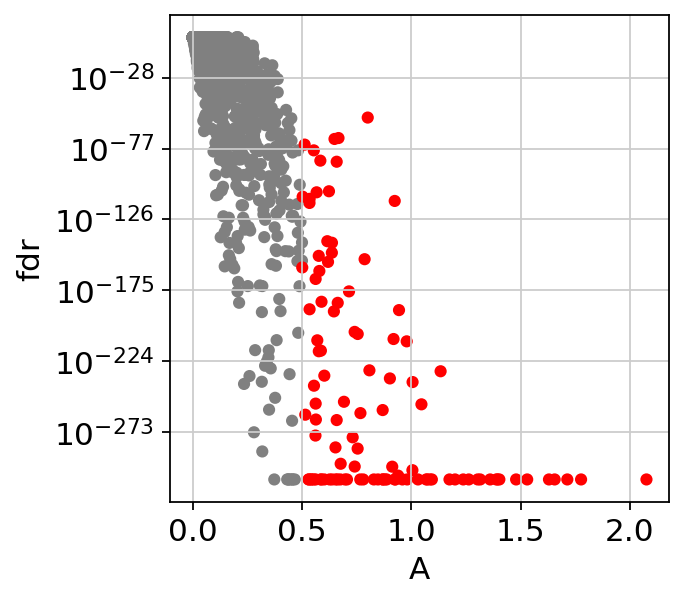

In [89]:
sc.set_figure_params()
scf.pl.test_association(adata)
plt.savefig("figures/C_v2.pdf",dpi=300)

In [90]:
scf.tl.fit(adata, n_jobs=20)

fit features associated with the trajectory
    single mapping :   7%|▋         | 8/108 [00:01<00:20,  4.84it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :   8%|▊         | 9/108 [00:09<01:45,  1.07s/it]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  31%|███▏      | 34/108 [00:19<00:42,  1.73it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  46%|████▋     | 50/108 [00:26<00:30,  1.92it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  59%|█████▉    | 64/108 [00:41<00:28,  1.54it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  70%|███████   | 76/108 [01:00<00:25,  1.25it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  81%|████████▏ | 88/108 [01:08<00:15,  1.28it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  94%|█████████▎| 101/108 [01:17<00:05,  1.30it/s]

by .GlobalEnv when processing object ‘aa’


    single mapping :  94%|█████████▍| 102/108 [01:24<00:04,  1.21it/s]

by .GlobalEnv when processing object ‘aa’


    single mapping :  95%|█████████▌| 103/108 [01:28<00:04,  1.17it/s]

by .GlobalEnv when processing object ‘aa’


    single mapping :  96%|█████████▋| 104/108 [01:35<00:03,  1.09it/s]

by .GlobalEnv when processing object ‘aa’


    single mapping :  98%|█████████▊| 106/108 [01:45<00:01,  1.00it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’


    single mapping : 100%|██████████| 108/108 [02:00<00:00,  1.12s/it]
    finished (adata subsetted to keep only fitted features!) (0:02:01) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

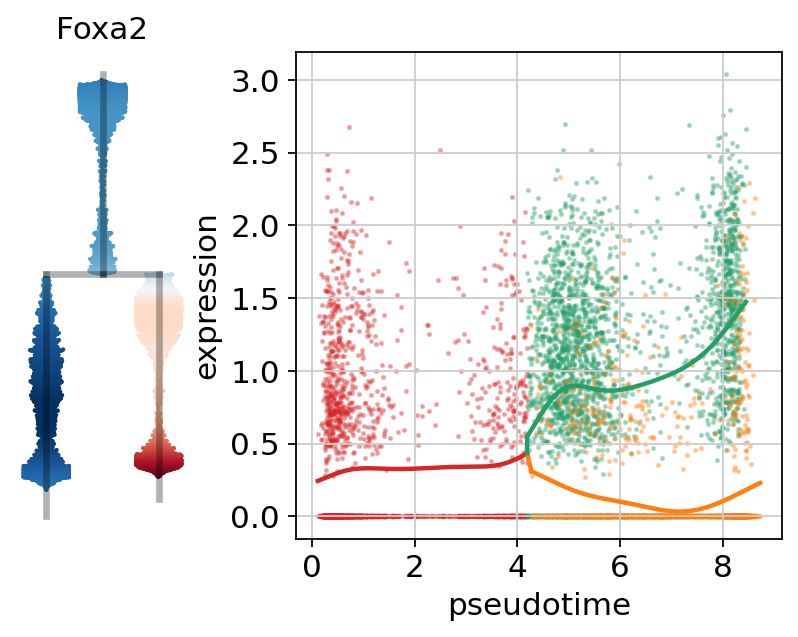

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

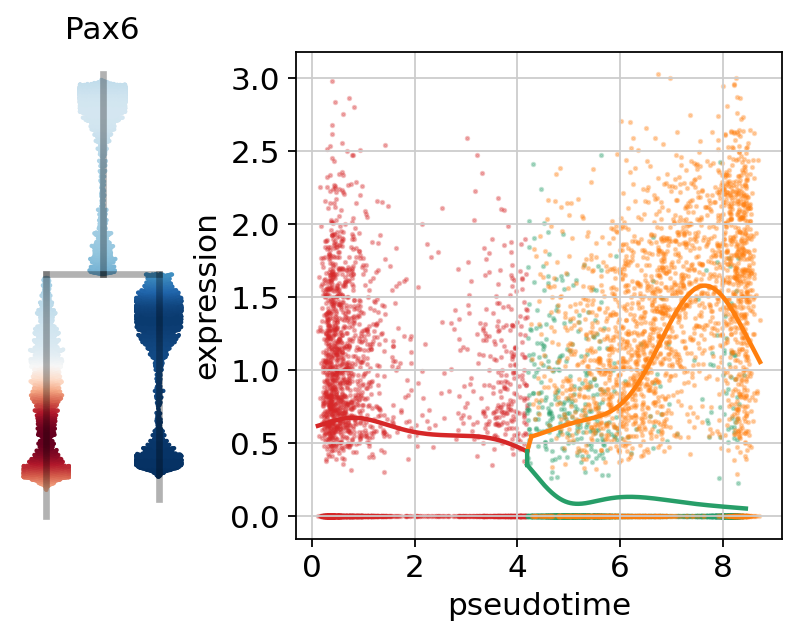

In [91]:
# Plotting single features
sc.set_figure_params(figsize=(.8,4),frameon=False)
scf.set_figure_pubready()
scf.pl.single_trend(adata,"Foxa2",basis="dendro",wspace=-.25,save="_E1.pdf")
scf.pl.single_trend(adata,"Pax6",basis="dendro",wspace=-.25,save="_E2.pdf")

In [92]:
outDir

'../results/scRNAseq_R13547_10x_mNT_20220813/RA_symetryBreaking/TF_modules/d3_d5_TFs_SPs_regressingCellCycle_v1/'

In [93]:
adata.write(os.path.join(outDir,'scFates_pseudotime_mNT_d3_d5_after.test.asssociation_v2_trajectory_fit.h5ad'), compression="gzip")

In [94]:
adata = sc.read_h5ad(os.path.join(outDir,'scFates_pseudotime_mNT_d3_d5_after.test.asssociation_v2_trajectory_fit.h5ad'),chunk_size=6000)

In [95]:
adata.layers["fitted"]

array([[ 4.77062357e-01,  2.34252143e-01,  3.02508033e-03, ...,
         2.66158280e-03,  7.13436150e-03, -5.03734648e-05],
       [ 1.50199281e-01,  2.40064183e-01,  4.10698094e-03, ...,
         2.01031383e-03,  5.63834185e-03,  3.46143663e-05],
       [ 1.68830926e-01,  2.39696020e-01,  3.96804645e-03, ...,
         2.07468927e-03,  5.67656328e-03,  1.03455086e-05],
       ...,
       [ 3.46025020e-03,  6.06868014e-01,  2.00657190e-01, ...,
         6.40130686e-01,  4.18936965e-03,  6.26269540e-01],
       [ 1.61742379e-02,  2.30191506e-02,  9.18128213e-01, ...,
         3.43390479e-01,  2.41566115e-01,  1.47426092e-03],
       [ 3.92736168e-01,  2.29284031e-01,  8.97308637e-03, ...,
         4.88048969e-02,  3.91081646e-03,  7.17396125e-03]])

In [96]:
adata

AnnData object with n_obs × n_vars = 8000 × 108
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'iscell_dd', 'cell.id', 'percent.mt', 'DF_out', 'percent.rb', 'S.Score', 'G2M.Score', 'Phase', 'celltypes', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.7', 'clusters', 'time', 'dataset', 't', 'seg', 'edge', 't_sd', 'milestones'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'p_val', 'A', 'fdr', 'st', 'signi'
    uns: 'condition_colors', 'dendro_segments', 'draw_graph', 'graph', 'milestones_colors', 'neighbors', 'ppt', 'pseudotime_list', 'seg_colors', 'stat_assoc_list'
    obsm: 'X_R', 'X_dendro', 'X_draw_graph_fa', 'X_palantir', 'X_pca', 'X_pca2d', 'X_seurat_pca', 'X_seurat_umap', 'X_umap'
    varm: 'PCs'
    layers: 'fitted'
    obsp: 'connectivities', 'distances'

In [97]:
# All branches DE analysis
scf.tl.test_fork(adata,root_milestone="Root",milestones=["NP","FP"],n_jobs=20, rescale=True)

testing fork
    single mapping
    Differential expression:   0%|          | 0/108 [00:00<?, ?it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’


    Differential expression:   1%|          | 1/108 [01:00<1:47:03, 60.03s/it]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’


    Differential expression:   2%|▏         | 2/108 [01:00<53:44, 30.42s/it]  

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’


    Differential expression:   8%|▊         | 9/108 [01:05<12:02,  7.30s/it]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    Differential expression:  77%|███████▋  | 83/108 [01:15<00:22,  1.09it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    Differential expression:  99%|█████████▉| 107/108 [01:30<00:00,  1.18it/s]

by .GlobalEnv when processing object ‘aa’


    Differential expression: 100%|██████████| 108/108 [02:08<00:00,  1.19s/it]
    test for upregulation for each leave vs root
    upreg NP:  98%|█████████▊| 49/50 [00:00<00:00, 63.75it/s]

by .GlobalEnv when processing object ‘aa’


    upreg FP:  98%|█████████▊| 57/58 [00:00<00:00, 70.66it/s]

by .GlobalEnv when processing object ‘aa’


    upreg FP: 100%|██████████| 58/58 [00:47<00:00,  1.23it/s]
    finished (0:03:45) --> added 
    .uns['Root->NP<>FP']['fork'], DataFrame with fork test results.


In [98]:
adata.write(os.path.join(outDir,'scFates_pseudotime_mNT_d3_d5_after.test.asssociation_trajectory_fit_testFork.h5ad'), compression="gzip")

In [99]:
# Bifurcation analysis

In [104]:
adata = sc.read_h5ad(os.path.join(outDir, 'scFates_pseudotime_mNT_d3_d5_after.test.asssociation_trajectory_fit_testFork.h5ad'),chunk_size=6000)

In [107]:
# test the thresholding parameters
effect = 0.1
scf.tl.branch_specific(adata,root_milestone="Root", milestones=["NP","FP"], effect= effect, copy = True)
#scf.tl.branch_specific(adata,root_milestone="Root",milestones=["NP", "FP"], effect=0.2)

    branch specific features: NP: 22, FP: 17
    finished --> updated 
    .uns['Root->NP<>FP']['fork'], DataFrame updated with additionnal 'branch' column.


AnnData object with n_obs × n_vars = 8000 × 108
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'iscell_dd', 'cell.id', 'percent.mt', 'DF_out', 'percent.rb', 'S.Score', 'G2M.Score', 'Phase', 'celltypes', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.7', 'clusters', 'time', 'dataset', 't', 'seg', 'edge', 't_sd', 'milestones'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'p_val', 'A', 'fdr', 'st', 'signi'
    uns: 'Root->NP<>FP', 'condition_colors', 'dendro_segments', 'draw_graph', 'graph', 'milestones_colors', 'neighbors', 'ppt', 'pseudotime_list', 'seg_colors', 'stat_assoc_list'
    obsm: 'X_R', 'X_dendro', 'X_draw_graph_fa', 'X_palantir', 'X_pca', 'X_pca2d', 'X_seurat_pca', 'X_seurat_umap', 'X_umap'
    varm: 'PCs'
    layers: 'fitted'
    obsp: 'connectivities', 'distances'

In [108]:
scf.tl.branch_specific(adata,root_milestone="Root",milestones=["NP", "FP"], effect= effect)

    branch specific features: NP: 22, FP: 17
    finished --> updated 
    .uns['Root->NP<>FP']['fork'], DataFrame updated with additionnal 'branch' column.


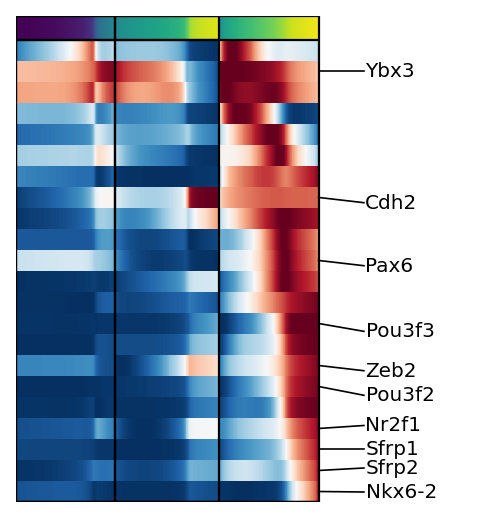

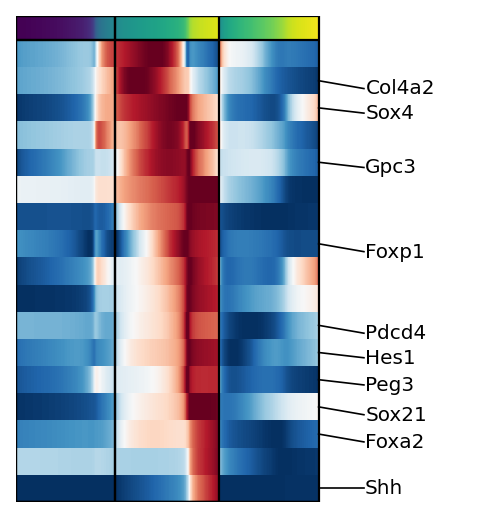

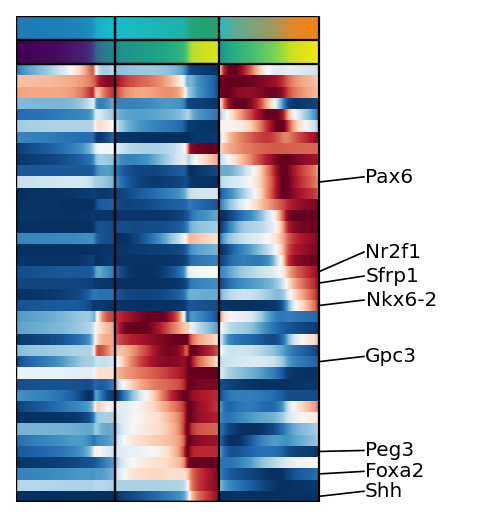

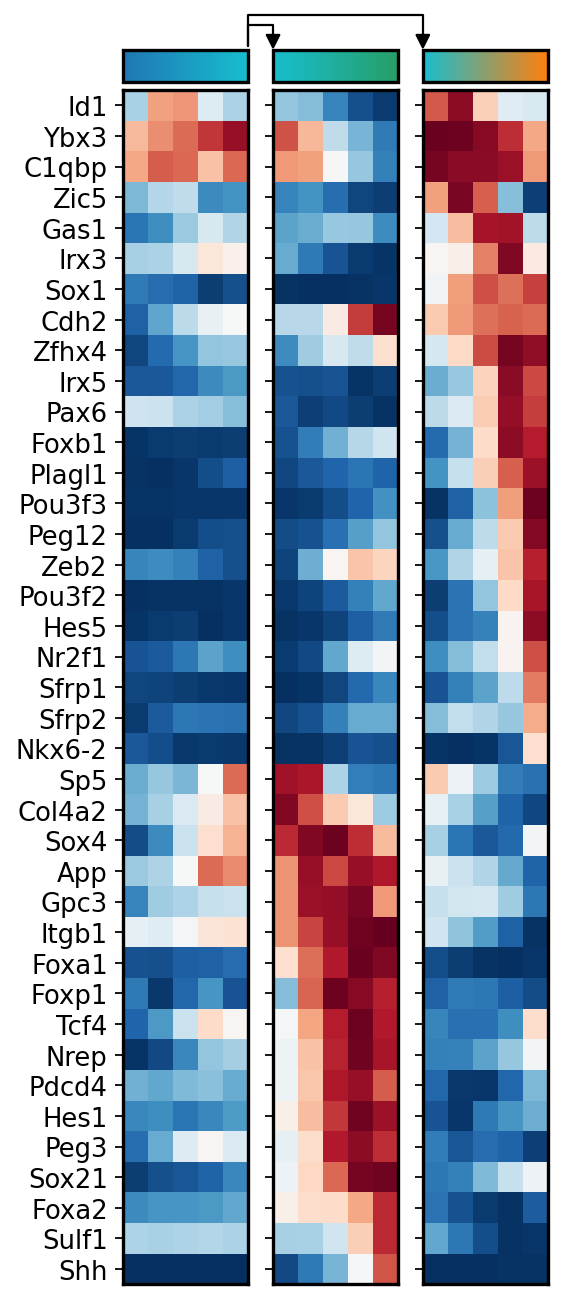

In [109]:
g1=scf.pl.trends(adata,
                 root_milestone="Root",
                 milestones=["NP","FP"],
                 branch="NP",
                 plot_emb=False,ordering="max",return_genes=True);
g2=scf.pl.trends(adata,
                 root_milestone="Root",
                 milestones=["NP", "FP"],
                 branch="FP",
                 plot_emb=False,ordering="max",return_genes=True);
gg=g1.tolist() + g2.tolist();
import matplotlib.pyplot as plt
g=scf.pl.trends(adata,gg,figsize=(4,4),annot="milestones",n_features=8,
        plot_emb=False,ordering=None,return_genes=True)
plt.savefig("figures/D.pdf",dpi=300);
# Displaying results using matrix plot
sc.set_figure_params()
scf.pl.matrix(adata,gg,norm="minmax",cmap="RdBu_r",colorbar=False,save="_F.pdf")

In [110]:
# Early gene detection

In [111]:
#scf.tl.activation_lm(adata,root_milestone="Root", milestones=["NP", "FP"], n_jobs=20)
scf.tl.activation_lm(adata, root_milestone="Root", milestones=["NP", "FP"], 
                     fdr_cut= 0.05,
                     stf_cut = 0.8,
                     n_jobs = 20,
                     copy = True
                    )

    single mapping
    prefork activation:  97%|█████████▋| 38/39 [00:00<00:00, 315.04it/s]

by .GlobalEnv when processing object ‘aa’


    prefork activation: 100%|██████████| 39/39 [00:56<00:00,  1.44s/it] 
    10 early and 12 late features specific to leave NP
    9 early and 8 late features specific to leave FP
    finished (0:03:30) --> updated 
    .uns['Root->NP<>FP']['fork'], DataFrame updated with additionnal 'slope','pval','fdr','prefork_signi' and 'module' columns.


AnnData object with n_obs × n_vars = 8000 × 108
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'iscell_dd', 'cell.id', 'percent.mt', 'DF_out', 'percent.rb', 'S.Score', 'G2M.Score', 'Phase', 'celltypes', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.7', 'clusters', 'time', 'dataset', 't', 'seg', 'edge', 't_sd', 'milestones'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'p_val', 'A', 'fdr', 'st', 'signi'
    uns: 'Root->NP<>FP', 'condition_colors', 'dendro_segments', 'draw_graph', 'graph', 'milestones_colors', 'neighbors', 'ppt', 'pseudotime_list', 'seg_colors', 'stat_assoc_list'
    obsm: 'X_R', 'X_dendro', 'X_draw_graph_fa', 'X_palantir', 'X_pca', 'X_pca2d', 'X_seurat_pca', 'X_seurat_umap', 'X_umap'
    varm: 'PCs'
    layers: 'fitted'
    obsp: 'connectivities', 'distances'

In [112]:
scf.tl.activation_lm(adata, root_milestone="Root", milestones=["NP", "FP"], 
                     #fdr_cut= 0.5, 
                     #pseudotime_offset = 0.4,
                     #stf_cut = 0.5,
                     n_jobs = 20,
                     copy = False
                    )

    single mapping
    prefork activation: 100%|██████████| 39/39 [00:00<00:00, 397.29it/s]
    10 early and 12 late features specific to leave NP
    9 early and 8 late features specific to leave FP
    finished (0:00:00) --> updated 
    .uns['Root->NP<>FP']['fork'], DataFrame updated with additionnal 'slope','pval','fdr','prefork_signi' and 'module' columns.


/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


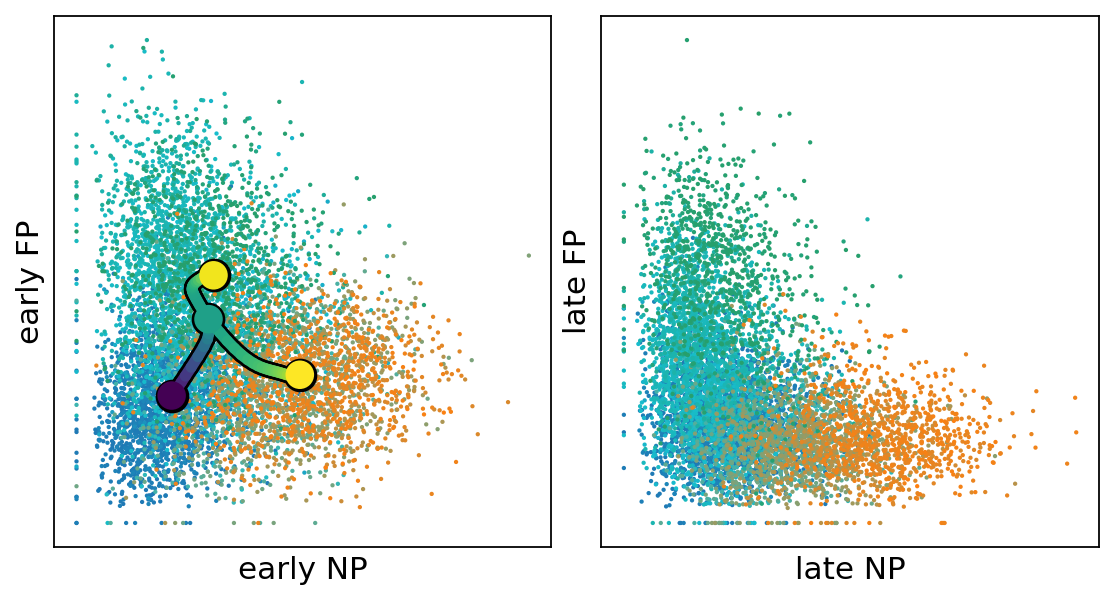

In [113]:
scf.pl.modules(adata,root_milestone="Root", milestones=["NP", "FP"],
               smooth=False, show_traj = True, module="all",save="_G_v2.pdf")

In [114]:
# extract the early and late modules
df=adata.uns["Root->NP<>FP"]["fork"].copy()
#df.index="\textit{"+df.index+"}"
eFP=df.index[(df.module=="early") & (df.branch=="FP")]
lFP=df.index[(df.module=="late") & (df.branch=="FP")]
eNP=df.index[(df.module=="early") & (df.branch=="NP")]
lNP=df.index[(df.module=="late") & (df.branch=="NP")]
import pandas as pd
dat=pd.DataFrame({'early FP': pd.Series(eFP), 
                  'late FP': pd.Series(lFP),
                  'early NP': pd.Series(eNP),
                  'late NP': pd.Series(lNP)})
dat=dat.fillna('')
dat

early FP late FP early NP late NP
0       Sp5   Sulf1    Zfhx4  Pou3f3
1      Gpc3   Foxa2    Sfrp2    Zeb2
2      Peg3   Foxp1     Ybx3    Pax6
3    Col4a2   Itgb1    Peg12     Id1
4     Sox21   Foxa1   Plagl1  Pou3f2
5      Sox4    Hes1     Irx3    Hes5
6       App   Pdcd4     Irx5  Nkx6-2
7      Nrep     Shh     Gas1    Sox1
8      Tcf4            Nr2f1   Sfrp1
9                       Cdh2    Zic5
10                             Foxb1
11                             C1qbp

In [115]:
dat.to_csv(os.path.join(outDir, 'scFates_early_late_modules_NP_FP_tl.test.fork.rescaled_v3.csv'))
#with open(os.path.join(outDir + "scFates_early_late_modules_NP_FP.txt"), 'w') as f:
#        f.write(dat)

In [121]:
# Repulsion of early gene modules
scf.tl.slide_cells(adata,root_milestone="Root",milestones=["NP", "FP"],win=2000)

--> added 
    .uns['Root->NP<>FP']['cell_freq'], probability assignment of cells on 5 non intersecting windows.


In [122]:
scf.tl.slide_cors(adata,root_milestone="Root",milestones=["NP", "FP"])

--> added 
    .uns['Root->NP<>FP']['corAB'], gene-gene correlation modules.


In [89]:
sc.set_figure_params()
scf.pl.slide_cors(adata,root_milestone="Root",milestones=["NP", "FP"],basis="umap", win_keep=[0,1,2,3,4,5,6],
                 focus=2, top_focus = 10, save="_H.pdf")

IndexError: list index out of range

In [113]:
# Local trend of module correlations
scf.tl.synchro_path(adata,root_milestone="Root", milestones=["NP", "FP"],w=100,n_map=50,n_jobs=20)

computing local correlations
    multi mapping:   0%|          | 0/50 [00:00<?, ?it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’


    multi mapping:   2%|▏         | 1/50 [01:32<1:15:46, 92.78s/it]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’


    multi mapping permutations: 100%|██████████| 50/50 [01:01<00:00,  1.24s/it]
    finished (0:03:17) --> added 
    .uns['Root->NP<>FP']['synchro'], mean local gene-gene correlations of all possible gene pairs inside one module, or between the two modules.
    .obs['inter_cor Root->NP<>FP'], GAM fit of inter-module mean local gene-gene correlations prior to bifurcation.


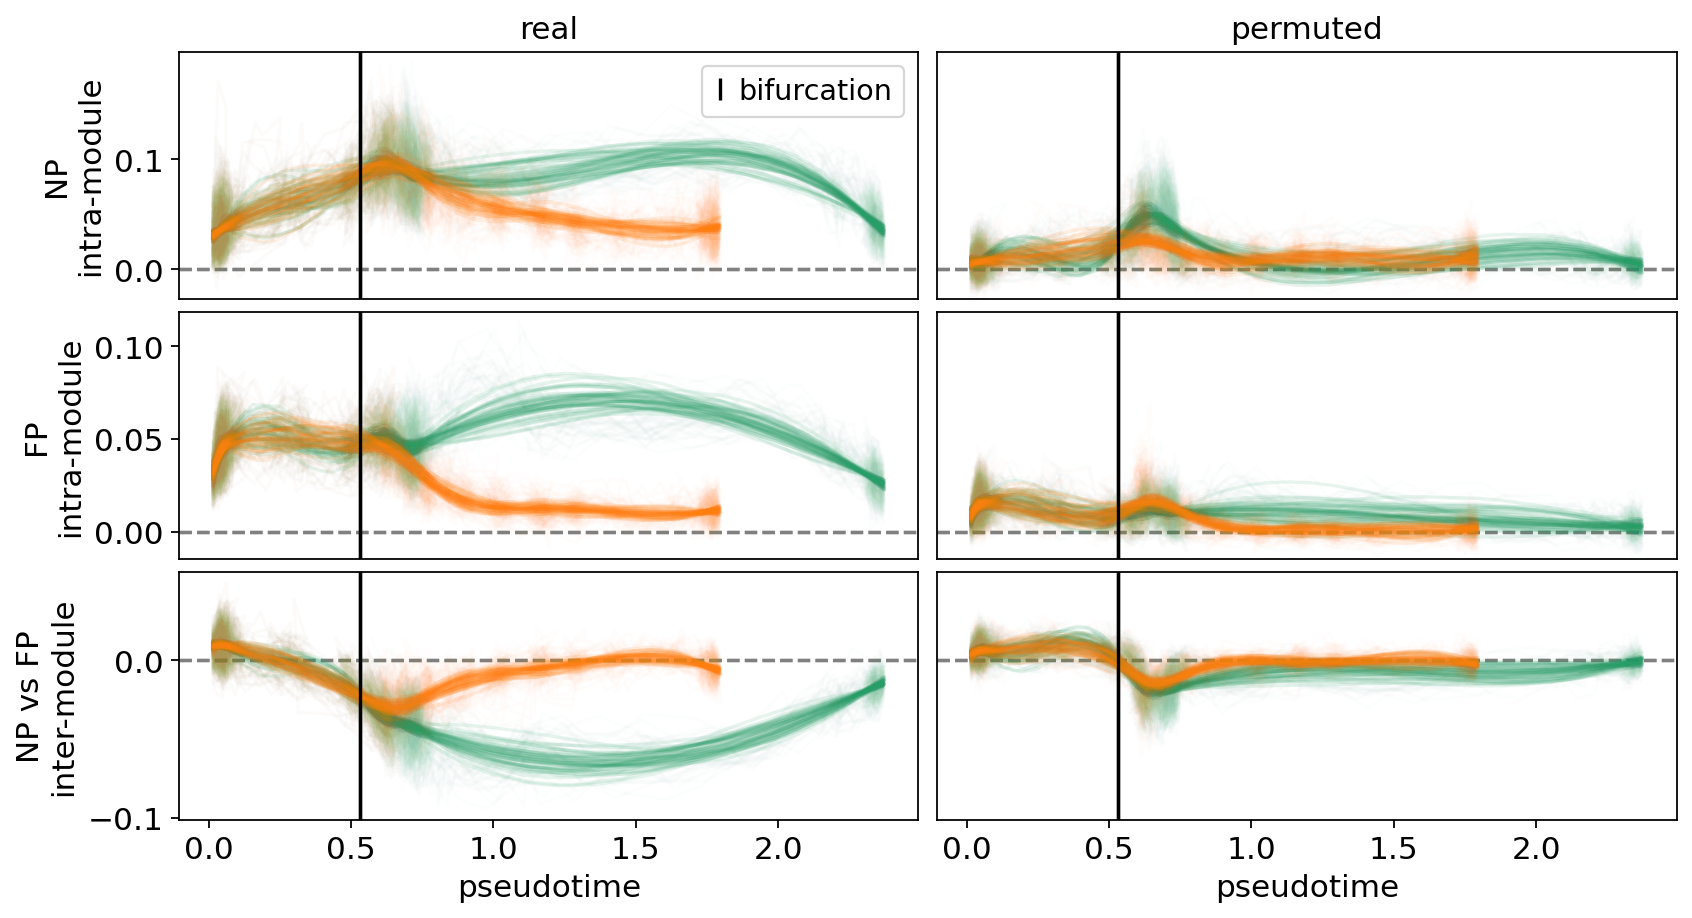

In [114]:
scf.pl.synchro_path(adata,root_milestone="Root", milestones=["NP", "FP"], save="_I.pdf")

In [48]:
# Formation of fate-specific modules

In [115]:
scf.tl.module_inclusion(adata,root_milestone="Root",milestones=["NP", "FP"], n_jobs=20,n_map=50, parallel_mode="mappings")

Calculating onset of features within their own module
    multi mapping: 100%|██████████| 50/50 [02:17<00:00,  2.75s/it]
    finished (0:02:17) --> added 
    .uns['Root->NP<>FP']['module_inclusion'], milestone specific dataframes containing inclusion timing for each gene in each probabilistic cells projection.
    .uns['Root->NP<>FP']['fork'] has been updated with the column 'inclusion'.


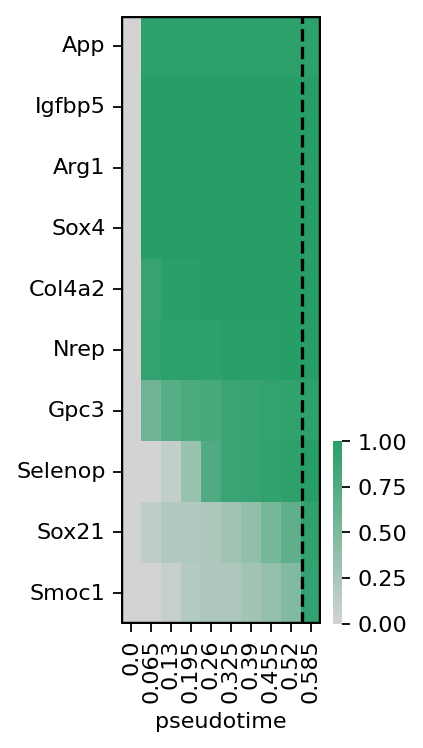

In [116]:
sc.set_figure_params(fontsize=10)
scf.pl.module_inclusion(adata,root_milestone="Root",milestones=["NP", "FP"],
                        bins=10,branch="NP",save="_J1.pdf",figsize=(2,5))

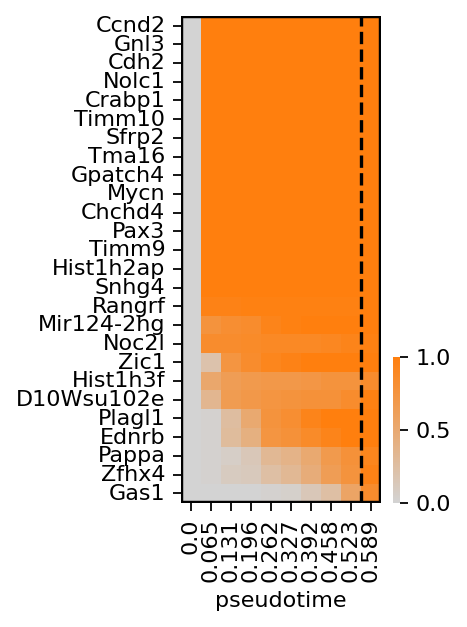

In [117]:
scf.pl.module_inclusion(adata,root_milestone="Root",milestones=["NP", "FP"],bins=10,branch="FP",
                       save="_J2.pdf",figsize=(2,4))